# Windy-cliff-walking setup

### Comparison of q-learning, SARSA and policy gradient


In [1]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import numpy as np
import pandas as pd

from matplotlib.colors import hsv_to_rgb


In [2]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [3]:
class GridWorld:
    terrain_color = dict(normal=[127.0/360, 0.0, 96.0/100],
                         objective=[26.0/360, 100.0/100, 100.0/100],
                         cliff=[247.0/360, 92.0/100, 70.0/100],
                         player=[344.0/360, 93.0/100, 100.0/100])
    
        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid,history = None):
        grid[-1, 1:11] = self.terrain_color['cliff']
        grid[-1, -1] = self.terrain_color['objective']
        if history is not None:
            for idx in history:
                grid[self._id_to_position(idx)] = self.terrain_color['player']
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], s='0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(12 * 4)]  
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        
    def reset(self):
        self.player = (3, 0)        
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions        
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        self._add_wind(self.player[1])            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _add_wind(self,x_loc):
        
        #wind_row = [0.4,0]
        #y_loc = 0 if self.player[0]%2 ==0 and self.player[1]%2 ==0 else 1
        p = np.random.random()
        if p<wind[x_loc] and self.player[0] < 3:
            self.player = (self.player[0]+1, self.player[1])
            
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, q_values=None, action=None,history = None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
            values = change_range(np.max(q_values, -1)).reshape(4, 12)
            grid[:, :, 1] = values
            self._add_objectives(grid,history)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(12), 4)
            ys = np.tile(np.arange(4), 12)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        #if action is not None:
            #self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        #plt.pause(0.01)

In [4]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']
wind = [0, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 0, 0.2, 0.0, 0, 0, 0]  # probability of being pushed down at column i
#wind = [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0] 

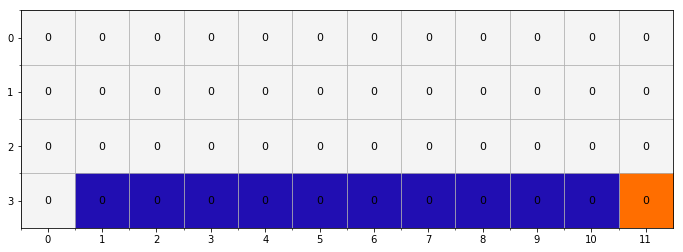

In [5]:
env = GridWorld()

We need a table of values that maps each state-action pair to a value, we'll create such table and initialize all values to zero (or to a random value)

In [6]:
# The number of states in simply the number of "squares" in our grid world, in this case 4 * 12
num_states = 4 * 12
# We have 4 possible actions, up, down, right and left
num_actions = 4

q_values = np.zeros((num_states, num_actions))

In [7]:
df = pd.DataFrame(q_values, columns=[' up ', 'down', 'right', 'left'])
df.index.name = 'States'

In [8]:
df.head()

,up,down,right,left
States,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [9]:
def egreedy_policy(q_values, state, epsilon=0.1):
    ''' 
    Choose an action based on a epsilon greedy policy.    
    A random action is selected with epsilon probability, else select the best action.    
    '''
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(q_values[state])

## Q-Learning

In [10]:
def q_learning(env, num_episodes=500, render=True, exploration_rate=0.1,
               learning_rate=0.5, gamma=0.9):    
    q_values = np.zeros((num_states, num_actions))
    ep_rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()    
        done = False
        reward_sum = 0

        while not done:            
            # Choose action        
            action = egreedy_policy(q_values, state, exploration_rate)
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            # Update q_values       
            td_target = reward + 0.9 * np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            # Update state
            state = next_state

            if render:
                env.render(q_values, action=actions[action], colorize_q=True)
            
        ep_rewards.append(reward_sum)
    
    return ep_rewards, q_values

In [11]:
q_learning_rewards, q_values = q_learning(env, gamma=0.9, learning_rate=1, render=False)

In [12]:
env.render(q_values, colorize_q=True)

In [13]:
np.mean(q_learning_rewards)

-38.156

500
Mean Reward: -34.996


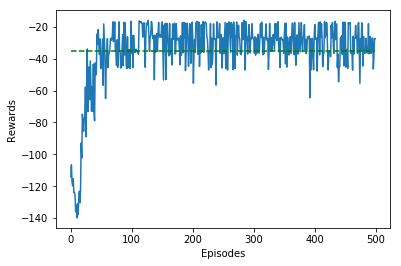

In [14]:
q_learning_rewards, _ = zip(*[q_learning(env, render=False, exploration_rate=0.1,
                                         learning_rate=1) for _ in range(10)])

avg_rewards = np.mean(q_learning_rewards, axis=0)

mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
print len(mean_reward)
fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))

## SARSA

In [15]:
def sarsa(env, num_episodes=500, render=True, exploration_rate=0.1,
          learning_rate=0.5, gamma=0.9):
    q_values_sarsa = np.zeros((num_states, num_actions))
    ep_rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()    
        done = False
        reward_sum = 0
        # Choose action        
        action = egreedy_policy(q_values_sarsa, state, exploration_rate)

        while not done:        
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            
            # Choose next action
            next_action = egreedy_policy(q_values_sarsa, next_state, exploration_rate)
            # Next q value is the value of the next action
            td_target = reward + gamma * q_values_sarsa[next_state][next_action]
            td_error = td_target - q_values_sarsa[state][action]
            # Update q value
            q_values_sarsa[state][action] += learning_rate * td_error

            # Update state and action        
            state = next_state
            action = next_action
            
            if render:
                env.render(q_values, action=actions[action], colorize_q=True)
                
        ep_rewards.append(reward_sum)
        
    return ep_rewards, q_values_sarsa

In [16]:
sarsa_rewards, q_values_sarsa = sarsa(env, render=False, learning_rate=0.5, gamma=0.99)

In [17]:
np.mean(sarsa_rewards)

-41.092

Mean Reward: -447.4156


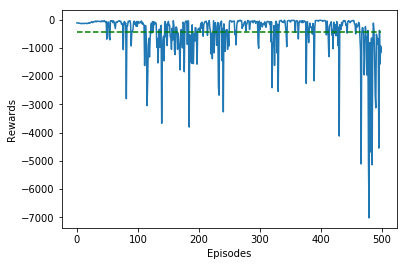

In [18]:
sarsa_rewards, _ = zip(*[sarsa(env, render=False, exploration_rate=0.1) for _ in range(10)])

avg_rewards = np.mean(sarsa_rewards, axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))

## Policy Gradient

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [20]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        #self.embedding = nn.Embedding(num_states, 3)
        self.fc1 = nn.Linear(num_states,75)
        self.fc2 = nn.Linear(75,num_actions+1) # extra 1 for q-value estimation 
        #self.drop = nn.Dropout(0.1)
        
        self.saved_log_probs = []
        self.rewards = []
        self.values = []
    def forward(self, x):

        x = torch.FloatTensor(1,num_states).zero_().scatter_(-1, x.unsqueeze(0),1.0)
        x = F.tanh(self.fc1(x))
        scores_values = self.fc2(x)
        scores = scores_values[:,:4]
        value = scores_values[:,4]
        return F.softmax(scores, dim=1),value
    
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=0.001)

In [21]:
def select_action(state):

    state = torch.LongTensor([state])

    probs,value = policy(state)
    m = Categorical(probs)
    #print probs
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item() , value.item()

def finish_episode():
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + 0.99 * R   # gamma = 0.9
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    #if len(policy.rewards)>1:
        #rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-10)
    pred = torch.tensor(policy.values)
    pred.requires_grad = True
    advantage = (rewards - pred).detach()
    value_est_loss = F.mse_loss(pred,rewards)
    

    for log_prob, reward in zip(policy.saved_log_probs,advantage):
        policy_loss.append(-log_prob * reward)
    optimizer.zero_grad()
    #optimizer_v.zero_grad()
    policy_loss = torch.cat(policy_loss).sum() + value_est_loss
    policy_loss.backward()
    #value_est_loss.backward()
    optimizer.step()
    #optimizer_v.step()


In [22]:
def policy_gradient(env, num_episodes=500,init_weights = True,train = True):
    global policy,optimizer
    if init_weights:
        policy = Policy()
        optimizer = optim.Adam(policy.parameters(), lr=0.0008)
    
    success = 0
    ep_rewards = []
    for i_episode in range(num_episodes):
        state = env.reset()
        reward_sum = 0
        for t in range(10000):  # Don't infinite loop while learning
            action,value = select_action(state)
            
            state, reward, done = env.step(action)
            reward_sum += reward
            #print action, env._id_to_position(state) 
            policy.rewards.append(reward)
            policy.values.append(value)
            if done:
                #print 'done',reward
                if reward == 0:
                    success += 1
                break

        if train:
            finish_episode()
        del policy.rewards[:]
        del policy.saved_log_probs[:]
        del policy.values[:]
        ep_rewards.append(reward_sum)
    return ep_rewards,success

In [23]:
def fill_q_values():
    q_values_pg = np.zeros((num_states, num_actions))
    global policy
    for s in range(num_states):
        state = torch.LongTensor([s])
        q_values_pg[s] = policy(state)[0].detach().numpy()
    return q_values_pg

In [24]:
ep_rewards,success = policy_gradient(env,num_episodes=7000) #the policy gradient method needs much more episodes to converge
success

4026

Mean Reward: -91.7790142857


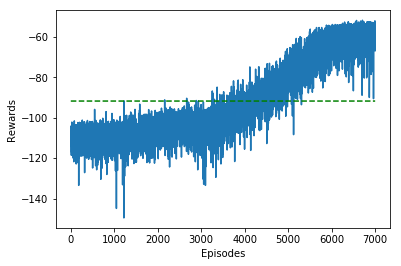

In [25]:
q_learning_pg_rewards, _ = zip(*[policy_gradient(env,7000) for _ in range(10)])

avg_rewards = np.mean(q_learning_pg_rewards, axis=0)

mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))


In [26]:
success = 0
while not success:
    _ ,success = policy_gradient(env,1,init_weights=False,train=True)

q_values_pg = fill_q_values()

## Visualization

In [27]:
def play(q_values):
    env = GridWorld()
    state = env.reset()
    done = False
    history = [state]
    for t in range(10000):    
        # Select action
        action = egreedy_policy(q_values, state, 0)
        # Do the action
        next_state, reward, done = env.step(action)  
        history.append(next_state)
        # Update state and action        
        state = next_state  
        #raw_input("Press Enter to continue...")
        env.render(q_values=q_values, action=actions[action],history=history, colorize_q=True)
        #raw_input("Press Enter to continue...")
        if done:
            return
    print 'path not found'

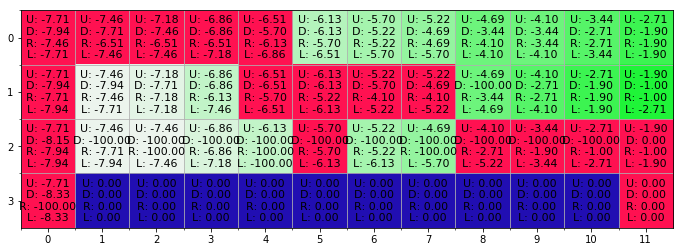

In [28]:
play(q_values)

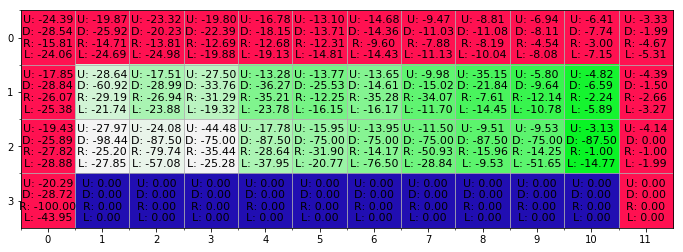

In [29]:
play(q_values_sarsa)

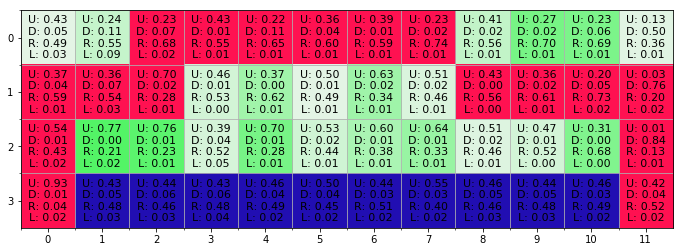

In [30]:
play(q_values_pg)